In [16]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt


In [19]:
# Try reading the CSV with 'latin-1' encoding
try:
    df = pd.read_csv('/content/data.csv', encoding='latin-1')
except UnicodeDecodeError:
    # If 'latin-1' fails, try 'ISO-8859-1'
    try:
        df = pd.read_csv('/content/data.csv', encoding='ISO-8859-1')
    except UnicodeDecodeError:
        print("Could not decode the file with 'latin-1' or 'ISO-8859-1'. Please check the file encoding.")

In [20]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [22]:
df = df[df['CustomerID'].notnull()]  # Remove rows without customer ID
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df = df[df['TotalPrice'] > 0]  # Remove refunds/negatives


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [26]:
# ----------------------------------------------------------
# STEP 3: Feature Engineering
# ----------------------------------------------------------
snapshot_date = df['InvoiceDate'].max()

cltv_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.min()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': ['sum', 'mean']
})

cltv_df.columns = ['recency', 'frequency', 'monetary', 'avg_order_value']
cltv_df = cltv_df.reset_index()
cltv_df['ltv'] = cltv_df['monetary']

In [27]:
# ----------------------------------------------------------
# STEP 4: Prepare Training Data
# ----------------------------------------------------------
features = ['recency', 'frequency', 'avg_order_value']
X = cltv_df[features]
y = cltv_df['ltv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
# ----------------------------------------------------------
# STEP 5: Train the Model
# ----------------------------------------------------------
# Import XGBRegressor from xgboost
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
# ----------------------------------------------------------
# STEP 6: Make Predictions and Evaluate
# ----------------------------------------------------------
# Import mean_absolute_error in addition to the other metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 1269.2889541145887
Root Mean Squared Error (RMSE): 5953.198983243816


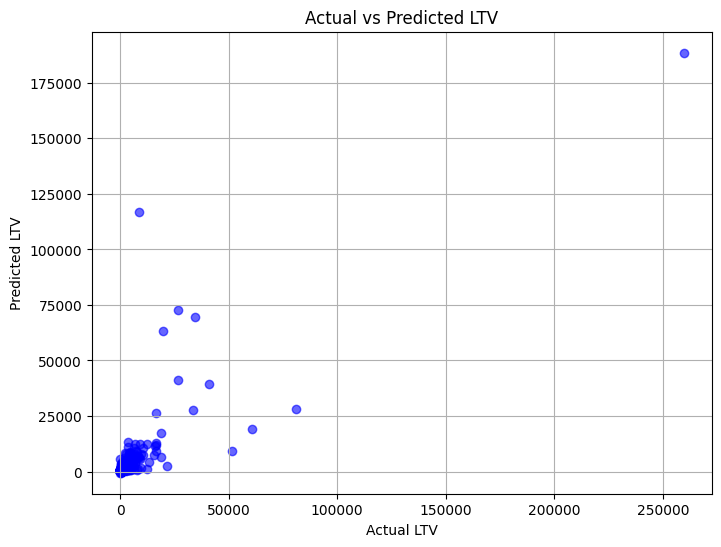

In [34]:
# ----------------------------------------------------------
# STEP 7: Visualize Predictions
# ----------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.xlabel("Actual LTV")
plt.ylabel("Predicted LTV")
plt.title("Actual vs Predicted LTV")
plt.grid(True)
plt.show()

In [35]:
# ----------------------------------------------------------
# STEP 8: Predict Full Dataset and Segment Customers
# ----------------------------------------------------------
cltv_df['predicted_ltv'] = model.predict(cltv_df[features])
cltv_df['segment'] = pd.qcut(cltv_df['predicted_ltv'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# ----------------------------------------------------------
# STEP 9: Export Final Results
# ----------------------------------------------------------
cltv_df.to_csv("cltv_predictions.csv", index=False)
print(cltv_df.groupby('segment')[['predicted_ltv']].mean())

           predicted_ltv
segment                 
Low           254.518921
Medium        547.413086
High         1124.403198
Very High    6315.644531


/tmp/ipython-input-35-216395784.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(cltv_df.groupby('segment')[['predicted_ltv']].mean())
